## 1) CIFAR-10  

 우리가 이번에 모델을 사용해서 풀어야 할 문제가 무엇인지 확인해보도록 합시다. CIFAR-10 데이터셋은 10개 카테고리에 대해 총 6만 장의 이미지가 있습니다. 각 이미지들의 가로, 세로는 각각 32 픽셀(pixel)입니다. MNIST에서 손글씨가 나타내는 숫자를 분류해내었던 것처럼 CIFAR-10 데이터셋을 사용해 물체의 종류를 분류해보도록 하겠습니다.

- CIFAR-10 from Tensorflow dataset
https://www.tensorflow.org/datasets/catalog/cifar10?hl=ko

### 1. 데이터셋 준비  

패키지 설치  

$ pip install tensorflow-datasets

### 2. 라이브러리 설치

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

❗️ tfds.load()는 기본적으로 ~/tensorflow_datasets 경로에 데이터셋을 다운로드합니다. 데이터셋 크기가 커서 하나의 폴더에 모아놓고 사용하는 것도 좋은 방법이므로, ~/aiffel 프로젝트 폴더가 아닌 기본 경로에 다운 받아 사용하시면 됩니다. 혹시 데이터셋 경로를 바꾸고 싶으시다면, data_dir 인자를 사용하세요.

In [3]:
import urllib3
urllib3.disable_warnings()
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.


(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
# print(ds_info.features)

In [5]:
# # 데이터의 개수도 확인해 봅시다. 
# print(tf.data.experimental.cardinality(ds_train))
# print(tf.data.experimental.cardinality(ds_test))

Tensorflow의 데이터셋은 Numpy가 아니므로 ds_train.shape 같은 게 존재하지 않습니다.

## 2) Input Normalization  

 이미지 데이터의 경우 픽셀 정보를 0~255 사이의 값으로 가지는데, 이를 255로 나누어주면 0~1.0 사이의 값으로 변경  
 
 Data Normalization을 하는 이유는 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 방지함  
 
 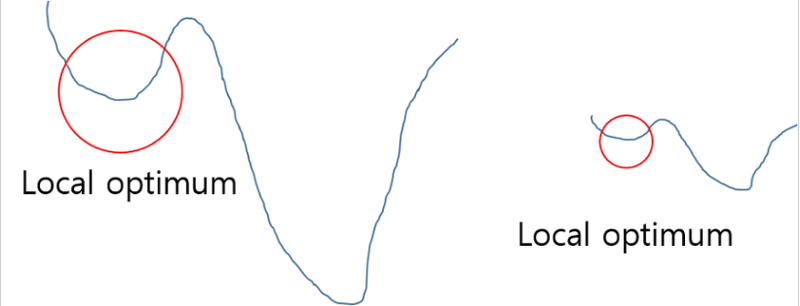

In [6]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [7]:
# 정규화 함수 적용 및 batch_size 조절

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

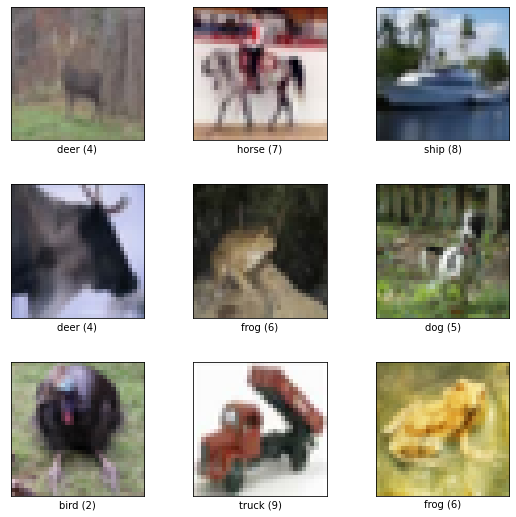

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

## 3) 블록 구성하기
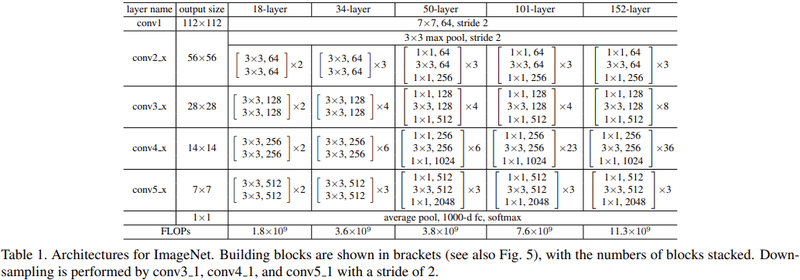
### ResNet 블록 만들기

In [10]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        stride = 1 if cnn_num > 0 else 2  # 첫 번째 레이어에서만 다운샘플링

        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

### ResNet 블록 만들기

In [11]:
from tensorflow import keras

def build_resnet_block(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1,
                       is_50=False,
                       is_plain=False):
    # 입력 레이어
    x = input_layer
    # skip connection을 위한 identity 저장
    identity = input_layer

    # ResNet-34 블록 (Basic Block)
    if not is_50:
        # num_cnn 만큼 Conv 레이어를 쌓음
        for cnn_num in range(num_cnn):
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3, 3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num + 1}'
            )(x)
            
            x = keras.layers.BatchNormalization(
                name=f'block{block_num}_bn_conv{cnn_num + 1}'
            )(x)

            x = keras.layers.Activation('relu',
                name=f'block{block_num}_activation{cnn_num + 1}'
            )(x)

    # ResNet-50 블록 (Bottleneck Block)
    else:
        # 첫 번째 1x1 Conv 레이어 (채널 수가 증가하지 않음)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1, 1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1_1x1'
        )(x)

        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_bn_conv1_1x1'
        )(x)

        x = keras.layers.Activation('relu',
            name=f'block{block_num}_activation1_1x1'
        )(x)

        # 두 번째 3x3 Conv 레이어 (채널 수 증가 없음)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2_3x3'
        )(x)

        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_bn_conv2_3x3'
        )(x)

        x = keras.layers.Activation('relu',
            name=f'block{block_num}_activation2_3x3'
        )(x)

        # 세 번째 1x1 Conv 레이어 (채널 수 증가)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1, 1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv3_1x1'
        )(x)

        # Skip Connection (차원 맞추기)
        if not is_plain:
            # 차원이 다르면 1x1 Conv로 skip connection의 차원 맞추기
            if identity.shape[-1] != channel * 4:
                identity = keras.layers.Conv2D(
                    filters=channel * 4,
                    kernel_size=(1, 1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_identity_conv_bottleneck'
                )(identity)

            x = keras.layers.Add(name=f'block{block_num}_skip_bottleneck')([x, identity])

    # 활성화 함수 (ReLU)
    x = keras.layers.Activation('relu', name=f'block{block_num}_final_activation')(x)
    
    return x


In [12]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3),name=f'input_layer')
resnet_block_output = build_resnet_block(resnet_input_layer)

# 블록 1개짜리 model 생성
resnet_model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

resnet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_bn_conv1 (BatchNormal (None, 32, 32, 64)        256       
_________________________________________________________________
block1_activation1 (Activati (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_bn_conv2 (BatchNormal (None, 32, 32, 64)        256       
_________________________________________________________________
block1_activation2 (Activati (None, 32, 32, 64)        0     

### ResNet-34 모델

In [13]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
                num_cnn_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10,
                is_50=False,  # ResNet-34는 Basic Block
                is_plain=False  # Skip Connection 포함
                ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    # 첫 CNN 레이어
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=(2, 2),
        kernel_initializer='he_normal',
        padding='same'
    )(input_layer)  

    # BatchNormalization 레이어
    output = keras.layers.BatchNormalization()(output)  

    # Activation 레이어
    output = keras.layers.Activation('relu')(output)  

    # Max Pooling 레이어
    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=(2,2),
#         name='initial_pooling'
    )(output)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        for j in range(num_cnn):
            # 첫 번째 레이어는 다운샘플링
            stride = 2 if j == 0 and i > 0 else 1  # 블록의 첫 번째 레이어는 다운샘플링

            # ResNet 블록 생성
            output = build_resnet_block(
                input_layer=output,
                num_cnn=2,  # Basic Block은 2개의 Conv 레이어
                channel=channel,
                block_num=f'{i+1}_{j+1}',  # 블록 및 레이어 번호
                is_50=is_50,  # ResNet-34는 Basic Block
                is_plain=is_plain  # Skip Connection 포함
            )   
        
    output = keras.layers.GlobalAveragePooling2D(
        name='avg_pool')(output)
#     output = keras.layers.Dense(1000, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [14]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
resnet_34 = build_resnet()

resnet_34.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
block1_1_conv1 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
block1_1_bn_conv1 (BatchNorm (None, 7, 7, 64)          256 

In [15]:
plain_34 = build_resnet(is_50=False, is_plain=True)

plain_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
block1_1_conv1 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
block1_1_bn_conv1 (BatchNorm (None, 7, 7, 64)          256 

## 4) ResNet-34와 ResNet-50 비교  

모델의 성능 비교를 위해서 모델을 훈련하고 평가

In [16]:
# batch size와 epoch 설정

BATCH_SIZE = 256
EPOCH = 5

In [17]:
# import tensorflow_datasets as tfds
# from utils import _generate_examples
# tfds.image_classification.cats_vs_dogs.CatsVsDogs._generate_examples = _generate_examples

# train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
# test_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)

In [18]:
# 데이터셋 정의

import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

TypeError: in user code:


    TypeError: tf__normalize_and_resize_img() missing 1 required positional argument: 'label'


In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    # steps_per_epoch : 한 번의 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수를 지정
    # validation_steps : 한 번의 에포크(epoch)가 끝날 때, 테스트에 사용되는 배치(batch)의 개수를 지정
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # use_multiprocessing=True,
)

In [ ]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    # steps_per_epoch : 한 번의 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수를 지정
    # validation_steps : 한 번의 에포크(epoch)가 끝날 때, 테스트에 사용되는 배치(batch)의 개수를 지정
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # use_multiprocessing=True,
)

### 그래프 비교

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

In [ ]:
# Out Of Memory 문제 방지 (메모리 청소)

tf.keras.backend.clear_session()

### 회고

이번 프로젝트는 시간이 너무 부족했다.  
어제 학습 노드를 다 끝마치고 오늘 프로젝트에 집중할 시간이 충분했는데도
생각보다 모델을 구현하는 시간과 오류를 고치느라 시간을 많이 써서 결과를 확인하지 못해 아쉬웠다.....